In [1]:
import pandas as pd
import numpy as np

# Load model OOF prediction

In [2]:
models = ["rf", "knn", "lr", "mlp", "svm"]

In [3]:
vals = []
for model in models:
    vals.append(pd.read_csv("y_sval_pred_" + model + ".csv"))

In [4]:
vals[0]

,y_sval_pred_rf
0,0.180182
1,0.140605
2,0.221868
3,0.131567
4,0.138065
...,...
1547,0.230579
1548,0.148831
1549,0.184607
1550,0.261589


In [5]:
real_val_y = pd.read_csv('y_sval.csv')

In [6]:
train_lv2 = pd.concat([pd.concat([val for val in vals], axis=1), real_val_y], axis=1)

In [7]:
X_train = train_lv2.drop("y_sval", axis=1)
y = train_lv2.y_sval

# Stack with LinearRegression

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
reg = LinearRegression().fit(X_train, y)

In [10]:
reg.score(X_train, y)

0.5076432264180709

In [11]:
reg.coef_

array([0.34374543, 0.12085449, 0.77076586, 0.36198156, 0.07335962])

Logistic regression is more robust with less data

# Stack with random forest (Might overfit)

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [30]:
clf.fit(X_train, y)

RandomForestClassifier(max_depth=5, random_state=0)

In [31]:
clf.score(X_train, y)

0.9375

In [32]:
importances = clf.feature_importances_

In [33]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

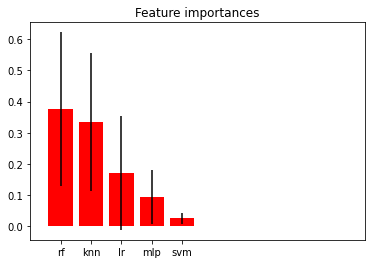

In [34]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), models)
plt.xlim([-1, 10])
plt.show()
# xgb.plot_importance(clf)

In [98]:
clf.predict_proba(X_train)[:, 1], y.values

(array([0.15656251, 0.08948349, 0.21096349, ..., 0.06643855, 0.11666552,
        0.7250091 ]),
 array([1, 0, 0, ..., 0, 0, 1]))

In [35]:
roc_auc_score(y.values, clf.predict_proba(X_train)[:, 1])

0.9681475623929165

# Stack with XGBoost (Less likely to overfit)

In [20]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [36]:
clf = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.005,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=-999,
    random_state=1111,
    tree_method='gpu_hist',  # THE MAGICAL PARAMETER
    use_label_encoder=False,
    eval_metric=roc_auc_score
)

In [37]:
clf.fit(X_train, y)

[21:09:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              eval_metric=<function roc_auc_score at 0x7f5fa70b2ca0>, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=-999, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [38]:
clf.score(X_train, y)

0.9310567010309279

In [39]:
roc_auc_score(y.values, clf.predict_proba(X_train)[:, 1])

0.9590701867893557

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

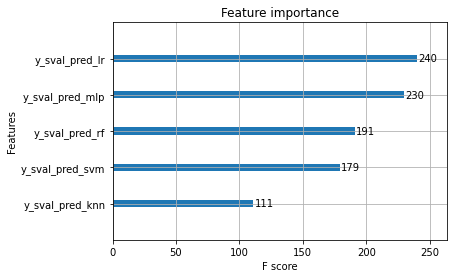

In [40]:
xgb.plot_importance(clf)

Agree with linear regression

# Check AUC score OOF prediction

In [28]:
roc_auc_score(train_lv2.y_sval.values, train_lv2.y_sval_pred_rf.values)

0.8513473035956052

In [22]:
train_lv2

,y_sval_pred_rf,y_sval_pred_knn,y_sval_pred_lr,y_sval_pred_mlp,y_sval_pred_svm,y_sval
0,0.180182,0.0,0.116309,1.873609e-06,0.119019,0
1,0.140605,0.2,0.083129,7.825891e-05,0.142589,0
2,0.221868,0.0,0.078647,5.658006e-05,0.055077,0
3,0.131567,0.0,0.088779,2.181454e-05,0.061832,0
4,0.138065,0.0,0.197455,4.175837e-04,0.056638,0
...,...,...,...,...,...,...
1547,0.230579,0.4,0.162762,1.700526e-01,0.088838,0
1548,0.148831,0.2,0.079736,3.585337e-07,0.060642,0
1549,0.184607,0.0,0.384712,9.616355e-01,0.859622,1
1550,0.261589,0.4,0.483030,5.752819e-01,0.305383,1


# Ensemble test result

In [46]:
tests = []
for model in models:
    tests.append(pd.read_csv("y_test_pred_" + model + ".csv"))

In [47]:
test_lv2 = pd.concat([test for test in tests], axis=1)

In [49]:
pred = clf.predict_proba(test_lv2)

In [50]:
pred

array([[0.4403348 , 0.5596652 ],
       [0.5759898 , 0.42401022],
       [0.5916296 , 0.40837035],
       ...,
       [0.5904659 , 0.4095341 ],
       [0.59810674, 0.40189323],
       [0.58795655, 0.41204345]], dtype=float32)

In [52]:
result = pd.DataFrame()
result['id'] = range(6015, 7661)
result['label'] = pred[:, 1]

In [53]:
result

,id,label
0,6015,0.559665
1,6016,0.424010
2,6017,0.408370
3,6018,0.596538
4,6019,0.474449
...,...,...
1641,7656,0.393397
1642,7657,0.411135
1643,7658,0.409534
1644,7659,0.401893


In [54]:
result.to_csv('results.csv', index=False, header=None)

## Distribution of probability of ensemble

(array([954., 240.,  78.,  68.,  56.,  46.,  28.,  45.,  52.,  79.]),
 array([0.39312515, 0.4134664 , 0.43380767, 0.45414895, 0.4744902 ,
        0.49483144, 0.5151727 , 0.535514  , 0.5558553 , 0.5761965 ,
        0.59653777], dtype=float32),
 <BarContainer object of 10 artists>)

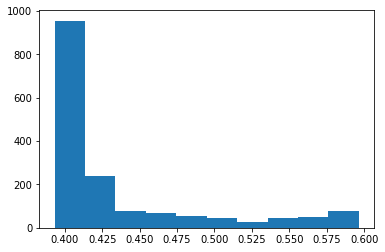

In [55]:
plt.hist(result.label)

(array([393., 550., 354., 154.,  46.,  24.,   6.,   1.,  12.,  12.]),
 array([0.07395273, 0.13034069, 0.18672865, 0.24311661, 0.29950457,
        0.35589253, 0.41228049, 0.46866845, 0.52505641, 0.58144437,
        0.63783233]),
 <BarContainer object of 10 artists>)

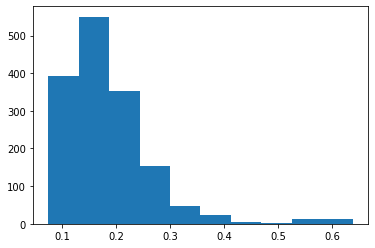

In [58]:
plt.hist(train_lv2.y_sval_pred_rf)